# Console Code to maintain the connection of CoLab



```
var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End");
    };

    var intervalId = setInterval(clickConnect, 300000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();
```



# Download arch library & NAB dataset

In [ ]:
!pip install arch -q
!git clone https://github.com/numenta/NAB.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.9/982.9 kB 12.5 MB/s eta 0:00:00
Cloning into 'NAB'...
remote: Enumerating objects: 7035, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 7035 (delta 51), reused 35 (delta 13), pack-reused 6915 (from 1)
Receiving objects: 100% (7035/7035), 86.75 MiB | 21.31 MiB/s, done.
Resolving deltas: 100% (4925/4925), done.
Updating files: 100% (1186/1186), done.


## 학습 데이터 살펴보기

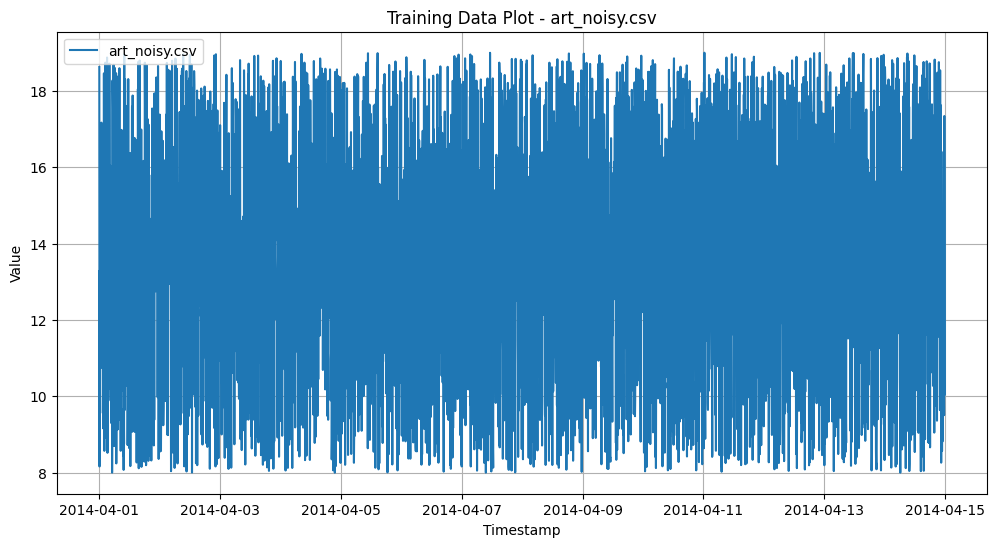

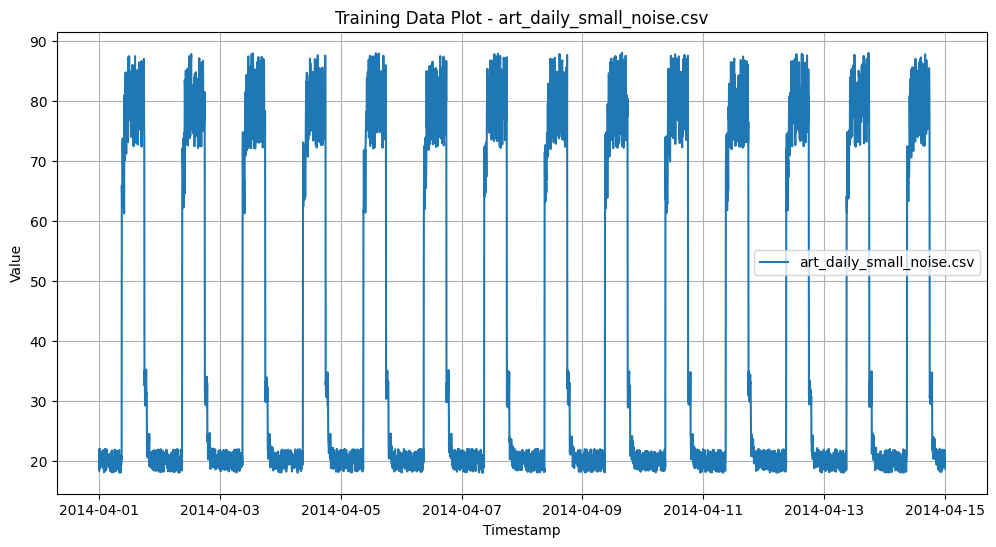

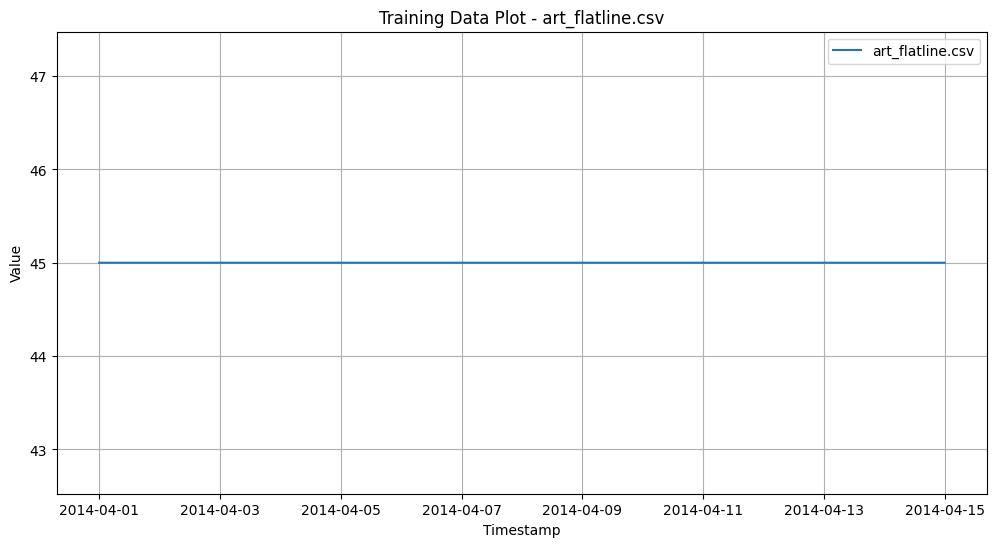

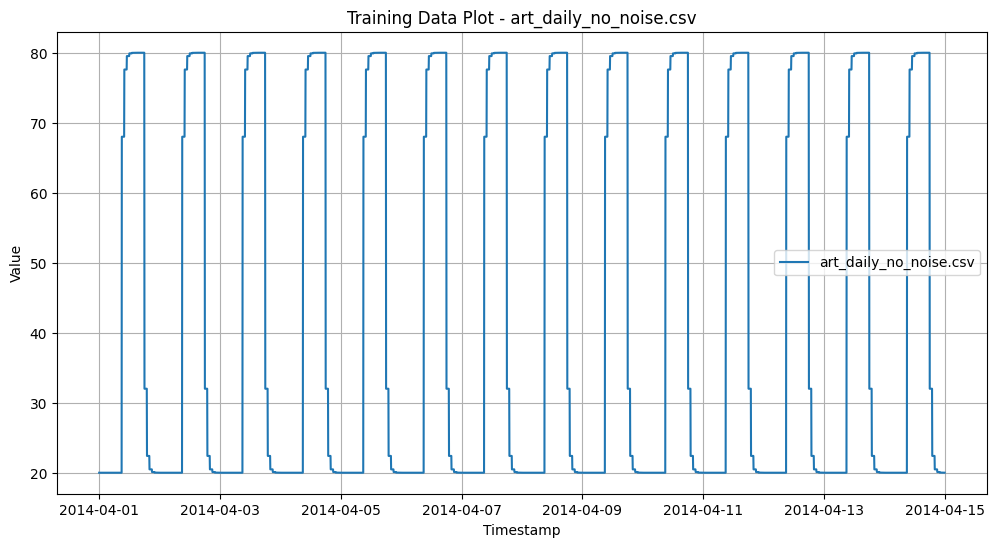

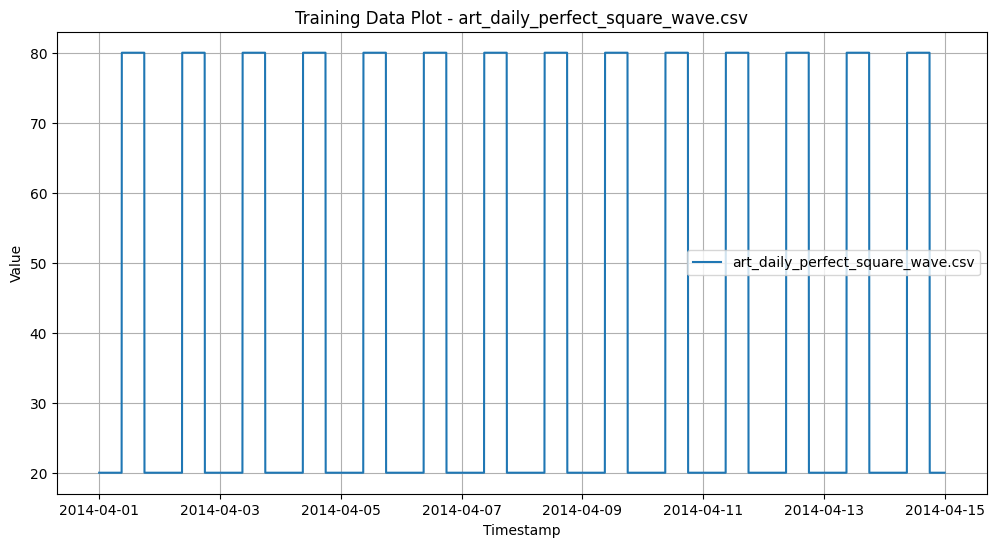

In [ ]:
# 학습 데이터 디렉토리 설정
train_data_dir = '/content/NAB/data/artificialNoAnomaly'

# 디렉토리 내의 모든 CSV 파일 불러오기
train_files = [f for f in os.listdir(train_data_dir) if f.endswith('.csv')]

max_plot_num = 10 # 최대 몇 개 데이터까지 plot을 만들지?
if len(train_files) > max_plot_num:
    train_files = train_files[:max_plot_num]


# 각 파일에 대해 데이터 로드 및 시각화
for train_file in train_files:
    train_data_file = os.path.join(train_data_dir, train_file)
    df_train = pd.read_csv(train_data_file)

    # 타임스탬프를 datetime 형식으로 변환
    df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
    df_train.set_index('timestamp', inplace=True)

    # 학습 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(df_train.index, df_train['value'], label=train_file)
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title(f'Training Data Plot - {train_file}')
    plt.legend()
    plt.grid(True)
    plt.show()

NAB/data/realKnownCause/ec2_request_latency_system_failure.csv에서 데이터를 로드 중...
데이터 로드 완료. 데이터 형태: (4032, 1)
NAB/labels/combined_labels.json에서 이상치 라벨을 로드 중...
라벨 로드 완료.
이상치 레이블을 찾기 위한 상대 경로: realKnownCause/ec2_request_latency_system_failure.csv
총 3개의 이상치가 감지되었습니다.


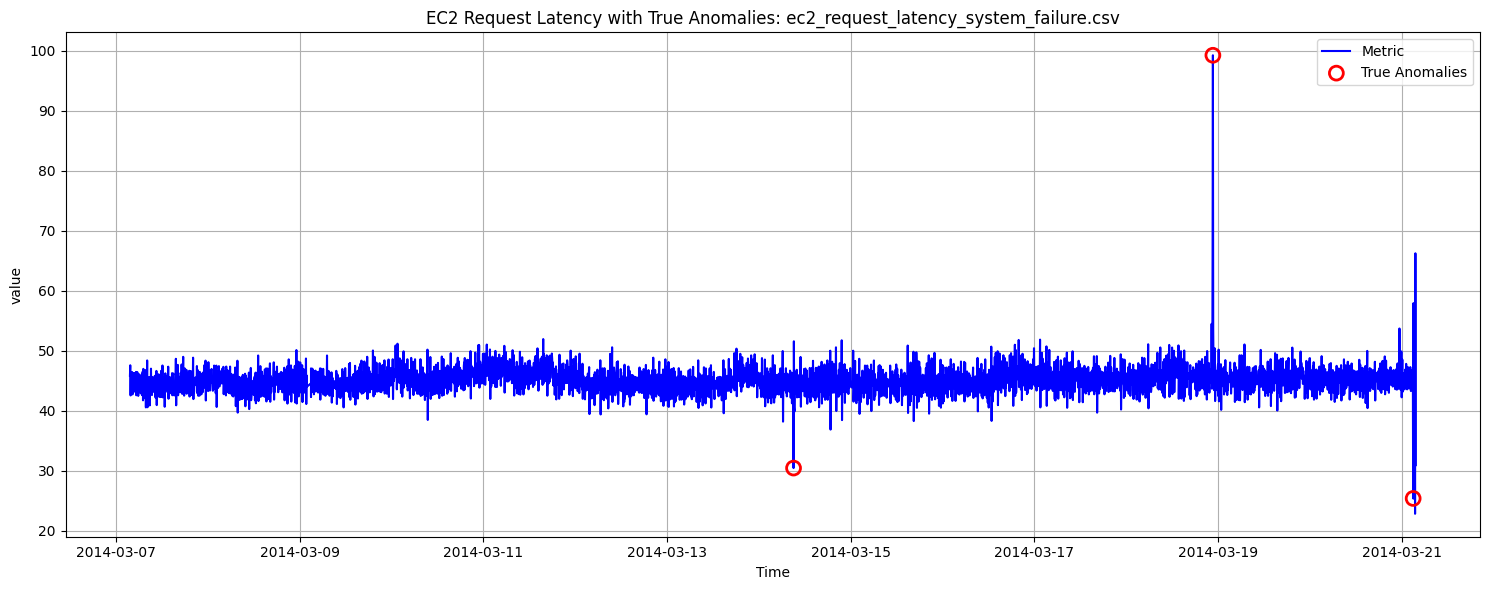

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, DataLoader, random_split
import seaborn as sns

def load_specific_csv(data_dir, csv_path='data/realKnownCause/ec2_request_latency_system_failure.csv'):
    full_csv_path = os.path.join(data_dir, csv_path)
    if not os.path.exists(full_csv_path):
        raise FileNotFoundError(f"CSV 파일을 찾을 수 없습니다: {full_csv_path}")

    print(f"{full_csv_path}에서 데이터를 로드 중...")
    df = pd.read_csv(full_csv_path)

    # 날짜 형식 변환 및 인덱스 설정
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    elif 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
    else:
        raise ValueError("CSV 파일에 타임스탬프 열을 찾을 수 없습니다.")

    df.sort_index(inplace=True)  # 인덱스 정렬

    print(f"데이터 로드 완료. 데이터 형태: {df.shape}")
    return df, os.path.basename(csv_path)

def load_anomaly_labels(labels_file='NAB/labels/combined_windows.json'):
    full_labels_path = labels_file
    if not os.path.exists(full_labels_path):
        raise FileNotFoundError(f"라벨 파일을 찾을 수 없습니다: {full_labels_path}")

    print(f"{full_labels_path}에서 이상치 라벨을 로드 중...")
    with open(full_labels_path, 'r') as f:
        labels = json.load(f)
    print("라벨 로드 완료.")
    return labels

def create_true_anomalies(df, labels, series_name):
    # 현재 테스트 데이터 파일의 상대 경로 (NAB/data를 기준으로)
    test_data_file_relative = os.path.join('realKnownCause', series_name)

    print(f"이상치 레이블을 찾기 위한 상대 경로: {test_data_file_relative}")

    # 해당 데이터 파일의 이상치 레이블 가져오기
    if test_data_file_relative not in labels:
        print(f"라벨 파일에 '{test_data_file_relative}' 키가 존재하지 않습니다.")
    anomaly_timestamps = labels.get(test_data_file_relative, [])

    if not anomaly_timestamps:
        print(f"'{test_data_file_relative}'에 대한 이상치 라벨이 없습니다.")

    # 이상치 레이블 생성
    true_anomalies = np.zeros(len(df), dtype=bool)
    time_index = df.index.to_pydatetime()

    for timestamp in anomaly_timestamps:
        anomaly_time = pd.to_datetime(timestamp, errors='coerce')
        if anomaly_time in df.index:
            true_anomalies[df.index == anomaly_time] = True

    num_detected_anomalies = np.sum(true_anomalies)
    print(f"총 {num_detected_anomalies}개의 이상치가 감지되었습니다.")

    return true_anomalies

def count_anomalies(labels_file='NAB/labels/combined_windows.json', target_series='realKnownCause/ec2_request_latency_system_failure.csv'):
    """
    특정 시리즈에 대한 이상치 구간의 개수와 세부 구간을 출력합니다.

    Parameters:
    - labels_file (str): JSON 라벨 파일의 경로.
    - target_series (str): 이상치 구간을 확인하고자 하는 시리즈의 상대 경로.
    """
    if not os.path.exists(labels_file):
        raise FileNotFoundError(f"라벨 파일을 찾을 수 없습니다: {labels_file}")

    with open(labels_file, 'r') as f:
        labels = json.load(f)

    anomalies = labels.get(target_series, [])

    if not anomalies:
        print(f"'{target_series}'에 대한 이상치 구간이 없습니다.")
    else:
        num_anomalies = len(anomalies)
        print(f"'{target_series}'에 대한 이상치 구간 개수: {num_anomalies}\n")
        print("이상치 구간 세부 정보:")
        for i, window in enumerate(anomalies, 1):
            start, end = window
            print(f"{i}. 시작: {start}, 종료: {end}")

def plot_anomalies(df, true_anomalies, series_name):
    plt.figure(figsize=(15, 6))

    metric_column = df.columns[0]  # 첫 번째 컬럼을 메트릭으로 사용
    plt.plot(df.index, df[metric_column], label='Metric', color='blue')

    # 실제 이상치 표시
    plt.scatter(df.index[true_anomalies],
                df.iloc[true_anomalies, 0],
                facecolors='none', edgecolors='red',
                label='True Anomalies', s=100, linewidths=2, zorder=5)

    # 플롯 설정
    plt.xlabel('Time')
    plt.ylabel(metric_column)
    plt.title(f'EC2 Request Latency with True Anomalies: {series_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

data_dir = 'NAB'
csv_path = 'data/realKnownCause/ec2_request_latency_system_failure.csv'
df, series_name = load_specific_csv(data_dir, csv_path)

# 라벨 로드
labels_file = os.path.join(data_dir, 'labels', 'combined_labels.json')
labels = load_anomaly_labels(labels_file)

# true_anomalies 생성
true_anomalies = create_true_anomalies(df, labels, os.path.basename(csv_path))

# 이상치 시각화
plot_anomalies(df, true_anomalies, os.path.basename(csv_path))

In [ ]:
target_series = 'realKnownCause/ec2_request_latency_system_failure.csv'
labels_file_path = 'NAB/labels/combined_windows.json'
count_anomalies(labels_file=labels_file_path, target_series=target_series)

'realKnownCause/ec2_request_latency_system_failure.csv'에 대한 이상치 구간 개수: 3

이상치 구간 세부 정보:
1. 시작: 2014-03-14 03:31:00.000000, 종료: 2014-03-14 14:41:00.000000
2. 시작: 2014-03-18 17:06:00.000000, 종료: 2014-03-19 04:16:00.000000
3. 시작: 2014-03-20 21:26:00.000000, 종료: 2014-03-21 03:41:00.000000


# Train for Anomaly Dectection

## Model Class 정의

In [ ]:
class sRLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, L, device, seed=None, forget_bias=1.0):
        super(sRLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.L = L
        self.device = device
        self.forget_bias = forget_bias
        self.f = nn.LSTMCell(input_size, hidden_size)
        self.f_prime = nn.LSTMCell(input_size, hidden_size)
        self.w_t_list = []
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random.RandomState()

        # 포겟 게이트 바이어스 추가
        for name, param in self.f.named_parameters():
            if 'bias' in name:
                param.data[self.hidden_size:2*self.hidden_size] += forget_bias
        for name, param in self.f_prime.named_parameters():
            if 'bias' in name:
                param.data[self.hidden_size:2*self.hidden_size] += forget_bias

    def generate_w_t(self):
        w_f = self.rng.randint(0, 2)
        w_f_prime = self.rng.randint(0, 2)
        while w_f == 0 and w_f_prime == 0:
            w_f = self.rng.randint(0, 2)
            w_f_prime = self.rng.randint(0, 2)
        return (w_f, w_f_prime)

    def forward(self, input, hx, cx, hx_L, cx_L):
        w_t = self.generate_w_t()
        self.w_t_list.append(w_t)
        w_f, w_f_prime = w_t
        outputs = torch.zeros_like(hx)
        count = 0

        if w_f == 1:
            hx_f, cx_f = self.f(input, (hx, cx))
            outputs += hx_f * w_f
            count += w_f
        else:
            hx_f = hx
            cx_f = cx

        if w_f_prime == 1 and hx_L is not None and cx_L is not None:
            hx_f_prime, cx_f_prime = self.f_prime(input, (hx_L, cx_L))
            outputs += hx_f_prime * w_f_prime
            count += w_f_prime
        else:
            # w_f_prime가 0이거나 hx_L, cx_L이 None인 경우
            hx_f_prime = hx_L
            cx_f_prime = cx_L

        if count > 0:
            outputs = outputs / count
        else:
            outputs = torch.zeros_like(hx)

        return outputs, hx_f, cx_f, hx_f_prime, cx_f_prime


class sRGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, L, device, seed=None, update_bias=1.0):
        super(sRGRUCell, self).__init__()
        self.hidden_size = hidden_size
        self.L = L
        self.device = device
        self.update_bias = update_bias  # 업데이트 게이트 바이어스
        self.f = nn.GRUCell(input_size, hidden_size)
        self.f_prime = nn.GRUCell(input_size, hidden_size)
        self.w_t_list = []
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random.RandomState()

        # 업데이트 게이트 바이어스 추가
        self._init_update_bias()

    def _init_update_bias(self):
        """업데이트 게이트의 바이어스를 조정하여 초기 업데이트 게이트의 동작을 조절"""
        for name, param in self.f.named_parameters():
            if 'bias' in name:
                # GRUCell의 bias는 [bias_z | bias_r | bias_n] 순서
                param.data[:self.hidden_size] += self.update_bias  # 업데이트 게이트 bias 조정
        for name, param in self.f_prime.named_parameters():
            if 'bias' in name:
                param.data[:self.hidden_size] += self.update_bias  # 업데이트 게이트 bias 조정

    def generate_w_t(self):
        w_f = self.rng.randint(0, 2)
        w_f_prime = self.rng.randint(0, 2)
        while w_f == 0 and w_f_prime == 0:
            w_f = self.rng.randint(0, 2)
            w_f_prime = self.rng.randint(0, 2)
        return (w_f, w_f_prime)

    def forward(self, input, hx, hx_L):
        w_t = self.generate_w_t()
        self.w_t_list.append(w_t)
        w_f, w_f_prime = w_t
        outputs = torch.zeros_like(hx)
        count = 0
        if w_f == 1:
            hx_f = self.f(input, hx)
            outputs += hx_f
            count += 1
        if w_f_prime == 1 and hx_L is not None:
            hx_f_prime = self.f_prime(input, hx_L)
            outputs += hx_f_prime
            count += 1
        if count > 0:
            outputs = outputs / count
        else:
            outputs = torch.zeros_like(hx)
        return outputs, hx_f if w_f == 1 else hx, hx_f_prime if w_f_prime == 1 else hx_L

class sRNNEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, cell_type='lstm', L=1, device='cpu', seed=None, forget_bias=1.0, update_bias=1.0):
        super(sRNNEncoder, self).__init__()
        self.hidden_size = hidden_size
        self.L = L
        self.cell_type = cell_type
        self.device = device
        self.seed = seed
        if cell_type == 'lstm':
            self.cell = sRLSTMCell(input_size, hidden_size, L, device, seed, forget_bias=forget_bias)
        elif cell_type == 'gru':
            self.cell = sRGRUCell(input_size, hidden_size, L, device, seed, update_bias=update_bias)
        else:
            raise ValueError("Unsupported cell type")
        self.w_t_list = []

    def forward(self, inputs):
        seq_len, batch_size, _ = inputs.size()
        if self.cell_type == 'lstm':
            hx = torch.zeros(batch_size, self.hidden_size, device=self.device)
            cx = torch.zeros(batch_size, self.hidden_size, device=self.device)
            hx_L = None
            cx_L = None
        else:
            hx = torch.zeros(batch_size, self.hidden_size, device=self.device)
            hx_L = None

        outputs = []
        self.cell.w_t_list = []
        for t in range(seq_len):
            input_t = inputs[t]
            if self.cell_type == 'lstm':
                output, hx, cx, hx_L, cx_L = self.cell(input_t, hx, cx, hx_L, cx_L)
            else:
                output, hx, hx_L = self.cell(input_t, hx, hx_L)
            outputs.append(output)
            # L 스텝 이전의 숨겨진 상태 업데이트
            if self.L > 0 and t >= self.L:
                if self.cell_type == 'lstm':
                    hx_L = outputs[t - self.L]
                    cx_L = cx
                else:
                    hx_L = outputs[t - self.L]
        outputs = torch.stack(outputs, dim=0)
        # 셀의 w_t_list를 인코더의 w_t_list에 저장
        self.w_t_list.extend(self.cell.w_t_list)
        return outputs, hx

class sRNNDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type='lstm', L=1, device='cpu', seed=None, forget_bias=1.0, update_bias=1.0):
        super(sRNNDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.L = L
        self.cell_type = cell_type
        self.device = device
        self.seed = seed
        if cell_type == 'lstm':
            self.cell = sRLSTMCell(input_size, hidden_size, L, device, seed, forget_bias=forget_bias)
        elif cell_type == 'gru':
            self.cell = sRGRUCell(input_size, hidden_size, L, device, seed, update_bias=update_bias)
        else:
            raise ValueError("Unsupported cell type")
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.w_t_list = []

        # 학습 가능한 초기 입력 파라미터 추가
        self.initial_input = nn.Parameter(torch.zeros(1, input_size))  # (1, input_size)

    def forward(self, encoder_outputs, encoder_hidden, seq_len):
        batch_size = encoder_hidden.size(0)
        if self.cell_type == 'lstm':
            hx = encoder_hidden
            cx = torch.zeros(batch_size, self.hidden_size, device=self.device)
            hx_L = None
            cx_L = None
        else:
            hx = encoder_hidden
            hx_L = None

        outputs = []
        # 학습 가능한 초기 입력을 배치 크기에 맞게 확장
        input_t = self.initial_input.expand(batch_size, -1).to(self.device)  # (batch_size, input_size)
        self.cell.w_t_list = []
        for t in reversed(range(seq_len)):
            if self.cell_type == 'lstm':
                output, hx, cx, hx_L, cx_L = self.cell(input_t, hx, cx, hx_L, cx_L)
            else:
                output, hx, hx_L = self.cell(input_t, hx, hx_L)
            output_processed = self.output_layer(output)
            outputs.append(output_processed)
            input_t = output_processed  # 다음 입력으로 사용
            # L 스텝 이전의 숨겨진 상태 업데이트
            if self.L > 0 and t >= self.L:
                if self.cell_type == 'lstm':
                    hx_L = hx
                    cx_L = cx
                else:
                    hx_L = hx
        outputs = torch.stack(outputs[::-1], dim=0)
        self.w_t_list.extend(self.cell.w_t_list)
        return outputs

class sRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type='lstm', L=1, device='cpu', seed=None, forget_bias=1.0, update_bias=1.0):
        super(sRNNModel, self).__init__()
        self.device = device
        self.seed = seed
        self.encoder = sRNNEncoder(input_size, hidden_size, cell_type, L, device, seed, forget_bias=forget_bias, update_bias=update_bias)
        self.decoder = sRNNDecoder(input_size, hidden_size, output_size, cell_type, L, device, seed, forget_bias=forget_bias, update_bias=update_bias)

    def forward(self, inputs):
        self.encoder.w_t_list = []
        self.decoder.w_t_list = []

        seq_len, batch_size, _ = inputs.size()
        encoder_outputs, encoder_hidden = self.encoder(inputs)
        outputs = self.decoder(encoder_outputs, encoder_hidden, seq_len)
        return outputs

class EnsembleSRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, cell_type='lstm', L=1, N=40, device='cpu', seed=None):
        super(EnsembleSRNNModel, self).__init__()
        self.N = N
        self.models = nn.ModuleList([
            sRNNModel(input_size, hidden_size, output_size, cell_type, L, device, seed + 1 + i if seed else None)
            for i in range(N)
        ])

    def forward(self, inputs):
        ensemble_outputs = []
        for model in self.models:
            outputs = model(inputs)
            ensemble_outputs.append(outputs)
        # 앙상블의 출력 결합 (예: 평균)
        ensemble_outputs = torch.stack(ensemble_outputs, dim=0).mean(dim=0)
        return ensemble_outputs

## random seed 고정

In [ ]:
def set_random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # 딥러닝 재현성을 위해 추가 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Setting for Train

In [ ]:
# 랜덤 시드 설정
random_seed = 777
set_random_seed(random_seed)  # 전체 코드의 재현성을 위해 시드 설정

# 디바이스 설정 (GPU가 있으면 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}")

# 하이퍼파라미터 설정
"""
<Outlier Detection for Time Series with Recurrent Autoencoder Ensembles>
[Hyperparameters Settings]
For all deep learning based methods, we use
Adadelta [Zeiler, 2012] as the optimizer, and we set
their learning rates to 10−3.
...
we set the number of hidden LSTM units to 8;
we set the default number of autoencoders N to
40, and we also study the effect of varying N from 10 to 40;
and we set λ to 0.005.
...
For MP, we set the pattern size to 10. # I think MP is Markov Process, and the pattern size is the state space of MP.
"""

# 하이퍼파라미터 설정
input_size = 1  # 단일 시계열
hidden_size = 8
output_size = 1
batch_size = 256
num_epochs = 10
learning_rate = 1e-3
cell_type = 'lstm'  # 'gru'도 가능
L = 2
seq_length = 288  # 시퀀스 길이 (1일 = 288 타임스텝 assuming 5분 간격)
N = 10  # 앙상블 모델 수
l1_lambda = 0.005  # L1 정규화 스케일

# 모델 수 설정
N = 40  # or 10, follow the paper

# 데이터 파일 경로 설정
data_file_path = 'NAB/data/realKnownCause/ec2_request_latency_system_failure.csv'  # 실제 데이터 파일 경로

label_file_path = 'NAB/labels/combined_labels.json'

# 데이터 로드
data = pd.read_csv(data_file_path, parse_dates=['timestamp'])

# 데이터 확인
print(data.head())
print(data.info())

사용 중인 디바이스: cuda
            timestamp   value
0 2014-03-07 03:41:00  45.868
1 2014-03-07 03:46:00  47.606
2 2014-03-07 03:51:00  42.580
3 2014-03-07 03:56:00  46.030
4 2014-03-07 04:01:00  44.992
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  4032 non-null   datetime64[ns]
 1   value      4032 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 63.1 KB
None


## TO-DO LIST
1. l1 정규화 파라미터 λ 값을 0.005로 설정
    - l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None) # in GitHub
2. Autoencoders 수의 변화 실험 (N from 10 to 40)

1. 시퀀스 단위로 데이터를 학습하지 않도록 수정 -> 각 데이터 포인트가 이상치인지 확인할 수 있도록
2. Walk-Forward 방식으로 Cross-Validation을 적용할 수 있을 것 (학습 시? 테스트 시?)
3. 정적 임계값, GARCH 또는 t-GARCH를 적용한 동적 임계값 적용 결과 비교

In [ ]:
# 'value' 컬럼만 사용하여 시계열 데이터 추출
values = data['value'].values.reshape(-1, 1)  # (4032, 1)

# 학습 데이터와 테스트 데이터 분할 (앞 7일 vs 뒤 7일)
train_size = 7 * 288  # 2016
test_size = 7 * 288  # 2016

train_data = values[:train_size]
test_data = values[train_size:]

# 데이터 정규화
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# 시퀀스 생성 함수
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

# 시퀀스 생성
train_sequences = create_sequences(train_scaled, seq_length)  # (2016 - 288 + 1, 288, 1) = (1729, 288, 1)
test_sequences = create_sequences(test_scaled, seq_length)    # (2016 - 288 + 1, 288, 1) = (1729, 288, 1)

print(f"학습 시퀀스 개수: {train_sequences.shape[0]}")
print(f"테스트 시퀀스 개수: {test_sequences.shape[0]}")

# Tensor 변환
train_tensor = torch.tensor(train_sequences, dtype=torch.float32)
test_tensor = torch.tensor(test_sequences, dtype=torch.float32)

# 데이터셋 생성 (Autoencoder: 입력과 타겟이 동일)
train_dataset = TensorDataset(train_tensor, train_tensor)
test_dataset = TensorDataset(test_tensor, test_tensor)

# 데이터로더 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 라벨 데이터 로드
with open(label_file_path, 'r') as f:
    labels = json.load(f)

# 시리즈 이름 (파일 이름)
series_name = 'ec2_request_latency_system_failure.csv'

# 테스트 데이터 프레임 생성 (시퀀스 생성 과정과 일치해야 함)
# 시퀀스의 마지막 타임스탬프를 인덱스로 설정
test_end_timestamps = data['timestamp'][train_size + seq_length -1 : train_size + len(test_sequences) + seq_length -1]

# 시퀀스의 마지막 타임스탬프만을 인덱스로 사용하여 test_df 생성
test_df = pd.DataFrame(index=pd.to_datetime(test_end_timestamps))
# 추가적인 컬럼이 필요하지 않다면 비워둘 수 있습니다.
# 그러나 만약 컬럼이 필요하다면, 더미 값을 할당할 수 있습니다.
test_df['dummy'] = 0  # 더미 컬럼 추가

# 실제 이상치 레이블 생성
def create_true_anomalies(df, labels, series_name, seq_length):
    """
    각 시퀀스가 이상치인지 여부를 나타내는 불리언 배열 생성

    Parameters:
    - df: 테스트 데이터 프레임 (시퀀스 생성에 사용된 데이터)
    - labels: 라벨 데이터 딕셔너리
    - series_name: 시리즈 이름 (파일 이름)
    - seq_length: 시퀀스 길이

    Returns:
    - sequence_labels: 시퀀스 단위의 이상치 레이블 (0 또는 1)
    """
    # 테스트 데이터 파일의 상대 경로 (NAB/data를 기준으로)
    test_data_file_relative = os.path.join('realKnownCause', series_name)

    print(f"이상치 레이블을 찾기 위한 상대 경로: {test_data_file_relative}")

    # 해당 데이터 파일의 이상치 레이블 가져오기
    if test_data_file_relative not in labels:
        print(f"라벨 파일에 '{test_data_file_relative}' 키가 존재하지 않습니다.")
    anomaly_timestamps = labels.get(test_data_file_relative, [])

    if not anomaly_timestamps:
        print(f"'{test_data_file_relative}'에 대한 이상치 라벨이 없습니다.")

    # 이상치 레이블 생성
    true_anomalies = np.zeros(len(df), dtype=bool)
    time_index = df.index.to_pydatetime()

    for timestamp in anomaly_timestamps:
        anomaly_time = pd.to_datetime(timestamp, errors='coerce')
        if pd.isna(anomaly_time):
            continue
        # 해당 타임스탬프가 데이터 프레임의 인덱스에 존재하는지 확인
        if anomaly_time in df.index:
            true_anomalies[df.index == anomaly_time] = True

    # 시퀀스 단위 레이블 생성
    sequence_labels = []
    for i in range(len(true_anomalies)):
        # 시퀀스의 마지막 타임스탬프가 이상치인 경우
        if true_anomalies[i]:
            sequence_labels.append(1)
        else:
            sequence_labels.append(0)

    num_true_anomalies = np.sum(sequence_labels)
    print(f"총 {num_true_anomalies}개의 실제 이상치 시퀀스가 존재합니다.")

    return np.array(sequence_labels)

# 실제 이상치 레이블 생성
true_sequence_labels = create_true_anomalies(test_df, labels, series_name, seq_length)

학습 시퀀스 개수: 1729
테스트 시퀀스 개수: 1729
이상치 레이블을 찾기 위한 상대 경로: realKnownCause/ec2_request_latency_system_failure.csv
총 2개의 실제 이상치 시퀀스가 존재합니다.


In [ ]:
# 모델 초기화
model = EnsembleSRNNModel(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    cell_type=cell_type,
    L=L,
    N=N,
    device=device,
    seed=random_seed
).to(device)

# 손실 함수 정의 (MSELoss)
criterion = nn.MSELoss()

# 옵티마이저 정의 (Adam)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.eval()

# 개별 데이터 포인트의 재구성 오류를 저장할 배열 초기화
# 전체 테스트 데이터 포인트 수는 train_size + test_size = 4032
# 하지만 시퀀스의 마지막 타임스탬프는 1729개의 포인트에 해당
# 따라서 재구성 오류를 해당 포인트에 할당

# 오류를 저장할 배열 (전체 테스트 데이터 포인트 수)
# 초기화는 False로 설정하거나 NaN으로 설정
point_errors = np.full(test_size, np.nan)  # NaN으로 초기화

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.permute(1, 0, 2).to(device)  # (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        outputs = model(inputs)
        # 시퀀스별 MSE 계산 (마지막 타임스텝만 사용)
        mse_per_sequence = torch.mean((outputs[-1] - inputs[-1]) ** 2, dim=1)  # (batch_size,)
        mse_per_sequence = mse_per_sequence.cpu().numpy()

        # 시퀀스의 마지막 타임스탬프 인덱스 계산
        # 현재 배치의 시퀀스 인덱스: batch_idx * batch_size + ...
        start_idx = batch_idx * batch_size
        end_idx = start_idx + len(mse_per_sequence)
        point_errors[start_idx:end_idx] = mse_per_sequence

# 임계값 설정 (3-sigma rule)
valid_errors = point_errors[~np.isnan(point_errors)]
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)
threshold = mean_error + 3 * std_error
print(f"임계값 (3-sigma): {threshold}")

# 이상치 탐지 (개별 데이터 포인트 단위)
predicted_point_labels = (point_errors > threshold).astype(int)  # 1: 이상치, 0: 정상

# 실제 이상치 레이블과 비교
# true_sequence_labels는 시퀀스의 마지막 타임스탬프에 대한 레이블
# 이를 데이터 포인트 단위 레이블로 변환

# 전체 테스트 데이터 포인트에 대한 실제 레이블 초기화
true_point_labels = np.zeros(test_size, dtype=int)

# 시퀀스의 마지막 타임스탬프에 대한 레이블을 해당 데이터 포인트에 할당
# 시퀀스의 마지막 타임스탬프 인덱스는 seq_length -1 부터 시작
for i, label in enumerate(true_sequence_labels):
    point_idx = i  # 시퀀스 인덱스
    true_point_labels[i] = label  # 시퀀스의 마지막 포인트에 레이블 할당

# 남은 포인트는 NaN으로 설정하거나 0으로 유지
# 여기서는 0으로 유지 (이상치가 아니라고 가정)

Epoch 1/10, Loss: 60.560372
Validation Loss: 0.068639
Epoch 2/10, Loss: 60.554883
Validation Loss: 0.068653
Epoch 3/10, Loss: 60.548742
Validation Loss: 0.068596
Epoch 4/10, Loss: 60.542593
Validation Loss: 0.068556
Epoch 5/10, Loss: 60.536535
Validation Loss: 0.068499
Epoch 6/10, Loss: 60.529962
Validation Loss: 0.068435
Epoch 7/10, Loss: 60.523544
Validation Loss: 0.068288
Epoch 8/10, Loss: 60.516868
Validation Loss: 0.068355
Epoch 9/10, Loss: 60.510197
Validation Loss: 0.068248
Epoch 10/10, Loss: 60.503392
Validation Loss: 0.067996


In [ ]:
model.eval()

# 개별 데이터 포인트의 재구성 오류를 저장할 배열 초기화
# 전체 테스트 데이터 포인트 수는 train_size + test_size = 4032
# 하지만 시퀀스의 마지막 타임스탬프는 1729개의 포인트에 해당
# 따라서 재구성 오류를 해당 포인트에 할당

# 오류를 저장할 배열 (전체 테스트 데이터 포인트 수)
# 초기화는 False로 설정하거나 NaN으로 설정
point_errors = np.full(test_size, np.nan)  # NaN으로 초기화

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.permute(1, 0, 2).to(device)  # (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        outputs = model(inputs)
        # 시퀀스별 MSE 계산 (마지막 타임스텝만 사용)
        mse_per_sequence = torch.mean((outputs[-1] - inputs[-1]) ** 2, dim=1)  # (batch_size,)
        mse_per_sequence = mse_per_sequence.cpu().numpy()

        # 시퀀스의 마지막 타임스탬프 인덱스 계산
        # 현재 배치의 시퀀스 인덱스: batch_idx * batch_size + ...
        start_idx = batch_idx * batch_size
        end_idx = start_idx + len(mse_per_sequence)
        point_errors[start_idx:end_idx] = mse_per_sequence

# 임계값 설정 (3-sigma rule)
valid_errors = point_errors[~np.isnan(point_errors)]
mean_error = np.mean(valid_errors)
std_error = np.std(valid_errors)
threshold = mean_error + 3 * std_error
print(f"임계값 (3-sigma): {threshold}")

# 이상치 탐지 (개별 데이터 포인트 단위)
predicted_point_labels = (point_errors > threshold).astype(int)  # 1: 이상치, 0: 정상

# 실제 이상치 레이블과 비교
# true_sequence_labels는 시퀀스의 마지막 타임스탬프에 대한 레이블
# 이를 데이터 포인트 단위 레이블로 변환

# 전체 테스트 데이터 포인트에 대한 실제 레이블 초기화
true_point_labels = np.zeros(test_size, dtype=int)

# 시퀀스의 마지막 타임스탬프에 대한 레이블을 해당 데이터 포인트에 할당
# 시퀀스의 마지막 타임스탬프 인덱스는 seq_length -1 부터 시작
for i, label in enumerate(true_sequence_labels):
    point_idx = i  # 시퀀스 인덱스
    true_point_labels[i] = label  # 시퀀스의 마지막 포인트에 레이블 할당


임계값 (3-sigma): 1.8678071001538858


In [ ]:
# 평가 지표 계산
roc_auc = roc_auc_score(true_point_labels, point_errors)
precision = precision_score(true_point_labels, predicted_point_labels, zero_division=0)
recall = recall_score(true_point_labels, predicted_point_labels, zero_division=0)
f1 = f1_score(true_point_labels, predicted_point_labels, zero_division=0)

print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix 출력
cm = confusion_matrix(true_point_labels, predicted_point_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 재구성 오차 분포 확인
plt.figure(figsize=(10, 5))
plt.hist(valid_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=mean_error, color='k', linestyle='--', label='Mean')
plt.axvline(x=threshold, color='r', linestyle='--', label='3-Sigma Threshold')
plt.title('Distribution of Reconstruction Errors')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 재구성 오차 시각화
plt.figure(figsize=(15, 5))
plt.plot(point_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (3-sigma)')
plt.title('Reconstruction Error and 3-Sigma Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 이상치 시퀀스 표시
plt.figure(figsize=(15, 5))
plt.plot(point_errors, label='Reconstruction Error')
plt.scatter(np.where(predicted_point_labels == 1)[0], point_errors[predicted_point_labels == 1], color='r', label='Detected Anomalies')
plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold (3-sigma)')
plt.title('Anomaly Detection with 3-Sigma Threshold')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 실제 이상치 시퀀스와 탐지된 이상치 시퀀스 비교 시각화 (Optional)
plt.figure(figsize=(15, 5))
plt.plot(point_errors, label='Reconstruction Error')
plt.scatter(np.where(true_point_labels == 1)[0], point_errors[true_point_labels == 1], color='b', label='True Anomalies')
plt.scatter(np.where(predicted_point_labels == 1)[0], point_errors[predicted_point_labels == 1], color='r', label='Detected Anomalies')
plt.axhline(y=threshold, color='g', linestyle='--', label='Threshold (3-sigma)')
plt.title('Anomaly Detection: True vs Detected Anomalies')
plt.xlabel('Data Point Index')
plt.ylabel('MSE')
plt.legend()
plt.show()

ValueError: Input contains NaN.

In [ ]:
# 일부 시퀀스의 입력과 재구성 출력 확인
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.permute(1, 0, 2).to(device)
        outputs = model(inputs)
        # 첫 번째 시퀀스 출력 확인
        plt.figure(figsize=(10, 5))
        plt.plot(inputs[:, 0, 0].cpu().numpy(), label='Input')
        plt.plot(outputs[:, 0, 0].cpu().numpy(), label='Reconstruction')
        plt.legend()
        plt.show()
        break  # 첫 배치만 확인